<div class="alert alert-block alert-info" style="margin-top: 20px">
<h1>Decision Trees and Random Forest - Regression</h1>
</div>
<p>In this project, I will use the car dataset and try to predict Selling Prices of cars by applying Decision Trees and Random Forest models. Afterwards, I will compare R2 and error scores for both models. In another notebook, I will implement Boosting models to the same dataset. </p>
<hr>

### Import Modules and Examine Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (9,5)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df=pd.read_csv("car_dataset.csv")
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.350,5.590,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.750,9.540,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.250,9.850,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.850,4.150,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.600,6.870,42450,Diesel,Dealer,Manual,0


In [3]:
df.shape

(301, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.isnull().any()

Car_Name         False
Year             False
Selling_Price    False
Present_Price    False
Kms_Driven       False
Fuel_Type        False
Seller_Type      False
Transmission     False
Owner            False
dtype: bool

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,301.000,2013.628,2.892,2003.000,2012.000,2014.000,2016.000,2018.000
Selling_Price,301.000,4.661,5.083,0.100,0.900,3.600,6.000,35.000
Present_Price,301.000,7.628,8.644,0.320,1.200,6.400,9.900,92.600
Kms_Driven,301.000,36947.206,38886.884,500.000,15000.000,32000.000,48767.000,500000.000
Owner,301.000,0.043,0.248,0.000,0.000,0.000,0.000,3.000


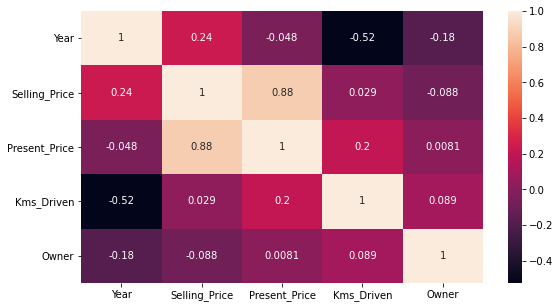

In [7]:
sns.heatmap(df.corr(), annot=True)
plt.show()

In [8]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.350,5.590,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.750,9.540,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.250,9.850,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.850,4.150,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.600,6.870,42450,Diesel,Dealer,Manual,0


In [9]:
# create a column for the age of the vehicles
df["vehicle_age"]=2022-df.Year

In [10]:
df.Car_Name.value_counts()

city                         26
corolla altis                16
verna                        14
fortuner                     11
brio                         10
ciaz                          9
innova                        9
i20                           9
grand i10                     8
jazz                          7
amaze                         7
Royal Enfield Classic 350     7
ertiga                        6
eon                           6
sx4                           6
alto k10                      5
i10                           5
swift                         5
Bajaj Pulsar 150              4
Royal Enfield Thunder 350     4
ritz                          4
wagon r                       4
etios liva                    4
dzire                         4
xcent                         3
etios cross                   3
Royal Enfield Thunder 500     3
TVS Apache RTR 160            3
Yamaha FZ S V 2.0             3
creta                         3
Honda CB Hornet 160R          3
etios g 

The feature "Car_Name" has lots of categories and most of them consist of just one value. If we apply get_dummies, it will generate unnecessary additional columns. This is what we avoid in tree-based models. So, there are two options: either we drop it, or we will use apply encoder method. Meanwhile, I implemented Decision Trees with get_dummies in another notebook by dropping both "Car_Name" and "Year" columns and I will share its results for comparison below.

In [11]:
# After creating a feature for the age of vehicles, we do not need "Year" column anymore.
df.drop(columns=["Year"], inplace=True)

In [12]:
df.head()

,Car_Name,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,vehicle_age
0,ritz,3.350,5.590,27000,Petrol,Dealer,Manual,0,8
1,sx4,4.750,9.540,43000,Diesel,Dealer,Manual,0,9
2,ciaz,7.250,9.850,6900,Petrol,Dealer,Manual,0,5
3,wagon r,2.850,4.150,5200,Petrol,Dealer,Manual,0,11
4,swift,4.600,6.870,42450,Diesel,Dealer,Manual,0,8


### Train | Test split

In [13]:
from sklearn.preprocessing import OrdinalEncoder

In [14]:
X=df.drop("Selling_Price", axis=1)
y=df.Selling_Price

### Encoder

Since our model is a tree-based model, we will apply the encoder method instead of get_dummies:

In [15]:
# first select object columns
cat = X.select_dtypes("object").columns
cat

Index(['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object')

In [16]:
X[cat].head()

,Car_Name,Fuel_Type,Seller_Type,Transmission
0,ritz,Petrol,Dealer,Manual
1,sx4,Diesel,Dealer,Manual
2,ciaz,Petrol,Dealer,Manual
3,wagon r,Petrol,Dealer,Manual
4,swift,Diesel,Dealer,Manual


In [17]:
enc = OrdinalEncoder()
X[cat] = enc.fit_transform(X[cat])
X.head()

,Car_Name,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,vehicle_age
0,90.000,5.590,27000,2.000,0.000,1.000,0,8
1,93.000,9.540,43000,1.000,0.000,1.000,0,9
2,68.000,9.850,6900,2.000,0.000,1.000,0,5
3,96.000,4.150,5200,2.000,0.000,1.000,0,11
4,92.000,6.870,42450,1.000,0.000,1.000,0,8


In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=5)

In [19]:
print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (240, 8)
Train target shape   :  (240,)
Test features shape  :  (61, 8)
Test target shape    :  (61,)


<div class="alert alert-block alert-info" style="margin-top: 20px">
<h2>Decision Trees</h2>
</div>

In [20]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [21]:
DT_model = DecisionTreeRegressor(random_state=101)

In [22]:
DT_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=101)

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [24]:
def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [25]:
train_val(DT_model, X_train, y_train, X_test, y_test)

,train,test
R2,1.000,0.952
mae,0.000,0.603
mse,0.000,1.283
rmse,0.000,1.133


#### The scores for Decision Trees with get_dummies for comparison:

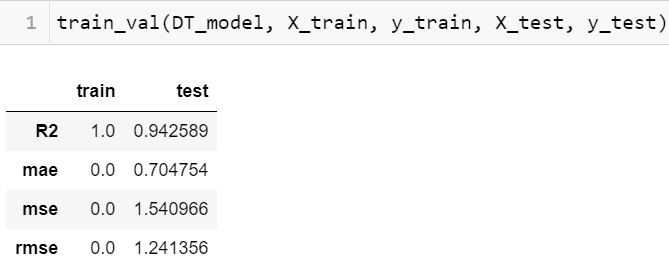

The R2 test score with encoder is higher than the model with get_dummies and we received lower error scores by using encoder. However, from the train scores, we can deduce that our model (with encoder or get_dummies) shows overfitting. First, we will check our scores with cross-validatoin to see whether they are consistent or not. Then, we will try GridSearchCV for Decision Trees. 

### Cross-Validation

In [26]:
from sklearn.model_selection import cross_validate, cross_val_score
model = DecisionTreeRegressor(random_state=101)
scores = cross_validate(model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv =10)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                             0.891
test_neg_mean_absolute_error       -0.787
test_neg_mean_squared_error        -2.748
test_neg_root_mean_squared_error   -1.457
dtype: float64

The difference between the scores without cross-validation and with cross-validation is huge. 

### Feature Importance for Decision Trees

In [27]:
DT_model.feature_importances_

array([9.18365194e-03, 8.94444598e-01, 4.78756069e-03, 7.75109283e-04,
       2.82862694e-04, 7.56380773e-04, 3.41291861e-05, 8.97357073e-02])

In [28]:
df_f_i = pd.DataFrame(index=X.columns, data = DT_model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance")
df_f_i

,Feature Importance
Owner,0.000
Seller_Type,0.000
Transmission,0.001
Fuel_Type,0.001
Kms_Driven,0.005
Car_Name,0.009
vehicle_age,0.090
Present_Price,0.894


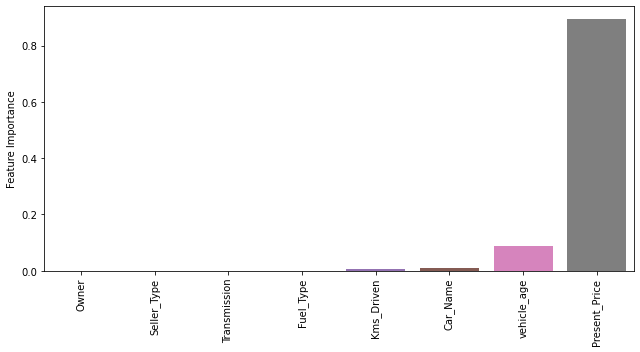

In [29]:
sns.barplot(x = df_f_i.index, y = 'Feature Importance', data = df_f_i)
plt.xticks(rotation = 90)
plt.tight_layout()

### Visualizing trees

In [30]:
from sklearn.tree import plot_tree

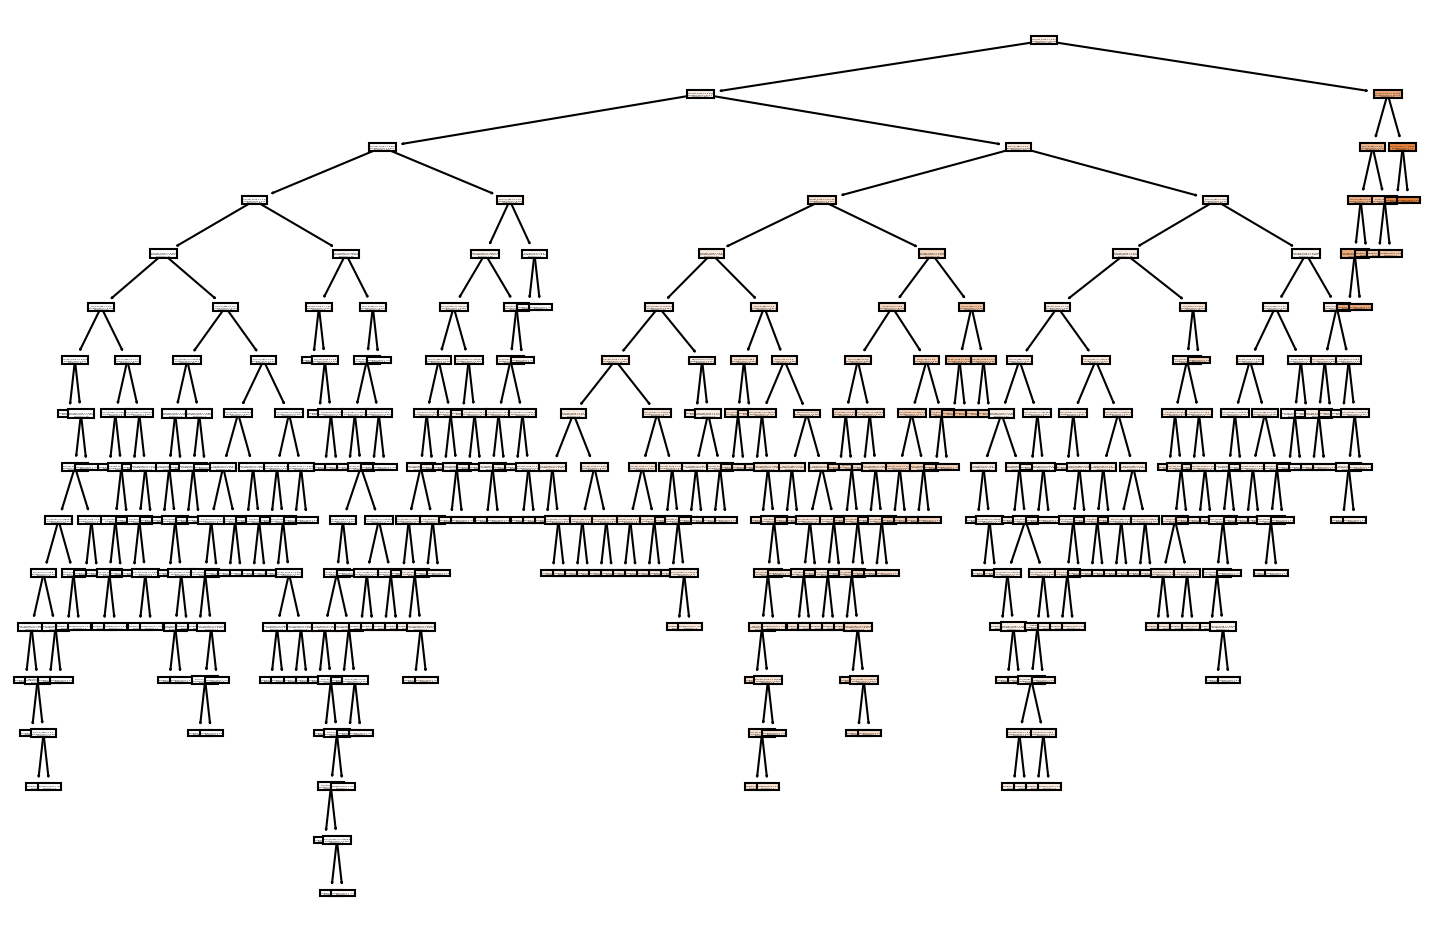

In [31]:
plt.figure(figsize=(12,8), dpi=150)
plot_tree(DT_model, filled=True, feature_names=X.columns);
plt.show()

In [32]:
def report_model(model):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print('\n')
    print(train_val(model, X_train, y_train, X_test, y_test))
    print('\n')
    plt.figure(figsize=(12,8),dpi=100)
    plot_tree(model,filled=True, feature_names=X.columns, fontsize=10);

In [33]:
#let's try for "max_depth=3"
pruned_tree = DecisionTreeRegressor(max_depth=3, random_state=101)
pruned_tree.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3, random_state=101)



      train  test
R2    0.871 0.784
mae   1.106 1.539
mse   3.278 5.787
rmse  1.810 2.406




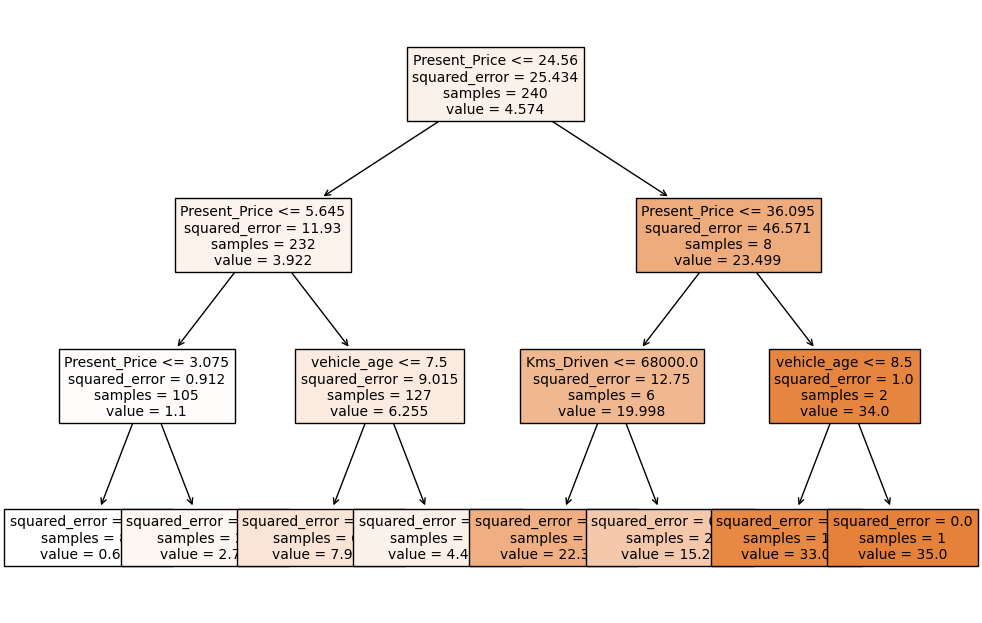

In [34]:
report_model(pruned_tree)
plt.show()

# Unlike classification, in the regression model, it gives values such as r2, instead of gini and entropy.
# With pruned_tree (max_depth =3), we avoid overfitting and have close scores in train and test sets.

### GridSearch for Decision Trees

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
model = DecisionTreeRegressor(random_state=101)

In [37]:
param_grid = {"splitter":["best", "random"],
            "max_depth": [None, 4, 5, 6, 7,8,9,10],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6,7],
             "min_samples_split": [2, 3, 5, 6, 7,8,9]}

# gridsearch ile teyiit ediyorz DT regression ile rmse değerleri uyumlu

In [38]:
grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1)

In [39]:
grid_model.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': [None, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 5, 6, 7, 8, 9],
                         'splitter': ['best', 'random']},
             scoring='neg_root_mean_squared_error')

In [40]:
grid_model.best_estimator_

DecisionTreeRegressor(max_depth=7, min_samples_split=7, random_state=101)

In [41]:
grid_model.best_params_

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'splitter': 'best'}

In [42]:
grid_score =pd.DataFrame(grid_model.cv_results_)
grid_score

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005,0.007,0.005,0.007,None,1,2,best,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-0.873,-1.055,-1.555,-0.892,-3.384,-0.820,-2.465,-1.016,-1.331,-1.179,-1.457,0.791,12
1,0.005,0.007,0.002,0.005,None,1,2,random,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-1.576,-1.161,-2.655,-0.624,-1.298,-2.433,-2.443,-1.270,-3.739,-4.999,-2.220,1.271,529
2,0.003,0.006,0.003,0.006,None,1,3,best,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-0.866,-0.895,-1.571,-0.904,-3.641,-0.833,-2.517,-0.928,-1.335,-1.071,-1.456,0.878,11
3,0.009,0.008,0.000,0.000,None,1,3,random,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-1.677,-1.274,-2.393,-1.920,-3.379,-1.767,-2.509,-0.875,-0.531,-4.883,-2.121,1.208,448
4,0.008,0.010,0.003,0.006,None,1,5,best,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-0.711,-0.791,-2.121,-0.756,-3.638,-1.008,-2.693,-0.852,-1.280,-4.185,-1.804,1.227,117
5,0.003,0.006,0.005,0.007,None,1,5,random,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-1.472,-0.930,-3.847,-0.797,-0.908,-1.619,-2.692,-0.679,-2.072,-5.374,-2.039,1.457,409
6,0.009,0.008,0.002,0.005,None,1,6,best,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-0.730,-0.864,-3.519,-0.704,-3.645,-0.949,-3.147,-0.837,-1.255,-4.167,-1.982,1.364,385
7,0.005,0.007,0.003,0.006,None,1,6,random,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-0.971,-1.337,-3.894,-0.645,-1.246,-1.511,-3.187,-1.556,-1.997,-5.347,-2.169,1.423,475
8,0.005,0.007,0.003,0.006,None,1,7,best,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-0.751,-0.882,-3.519,-0.726,-1.015,-1.044,-2.683,-0.782,-1.263,-3.240,-1.591,1.048,31
9,0.003,0.006,0.005,0.007,None,1,7,random,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-1.317,-1.240,-3.891,-1.588,-1.197,-1.657,-2.781,-0.839,-2.277,-6.311,-2.310,1.588,575


In [43]:
grid_model.best_index_

400

In [44]:
grid_model.best_score_

-1.3597620268388793

In [45]:
y_train_pred = grid_model.predict(X_train)

In [46]:
y_pred = grid_model.predict(X_test)

In [47]:
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.979,0.929
mae,0.375,0.745
mse,0.524,1.916
rmse,0.724,1.384


#### When I applied get_dummies in Decision Trees, I received lower R2 and higher error sores in the test set compared with the model with the encoder.

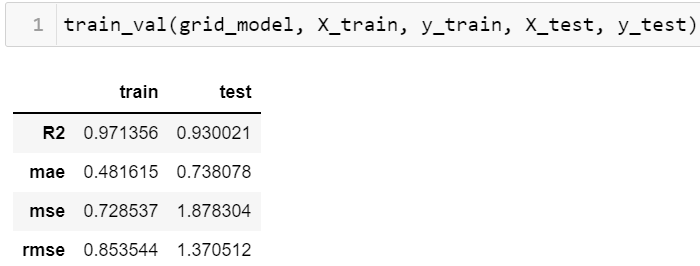

In [48]:
# to compare with the previous cross-validation score...
# let's apply cross-validation with the best_params that we received from GridSearchCV

from sklearn.model_selection import cross_validate, cross_val_score
model = DecisionTreeRegressor(random_state=101,max_depth = 7, min_samples_split= 7)
scores = cross_validate(model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv = 10)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                             0.902
test_neg_mean_absolute_error       -0.730
test_neg_mean_squared_error        -2.672
test_neg_root_mean_squared_error   -1.360
dtype: float64

It seems that we improved our cross-validation scores, too.

In [49]:
my_dict = { 'Actual': y_test, 'Pred': y_pred, 'Residual': y_test-y_pred }
compare = pd.DataFrame(my_dict)

In [50]:
comp_sample = compare.sample(20)
comp_sample

,Actual,Pred,Residual
21,4.900,5.150,-0.250
171,0.400,0.457,-0.057
115,1.110,1.173,-0.063
123,1.000,1.173,-0.173
252,5.400,5.931,-0.531
194,0.200,0.457,-0.257
216,2.900,3.007,-0.107
132,0.750,0.833,-0.083
66,19.750,15.995,3.755
99,9.650,4.833,4.817


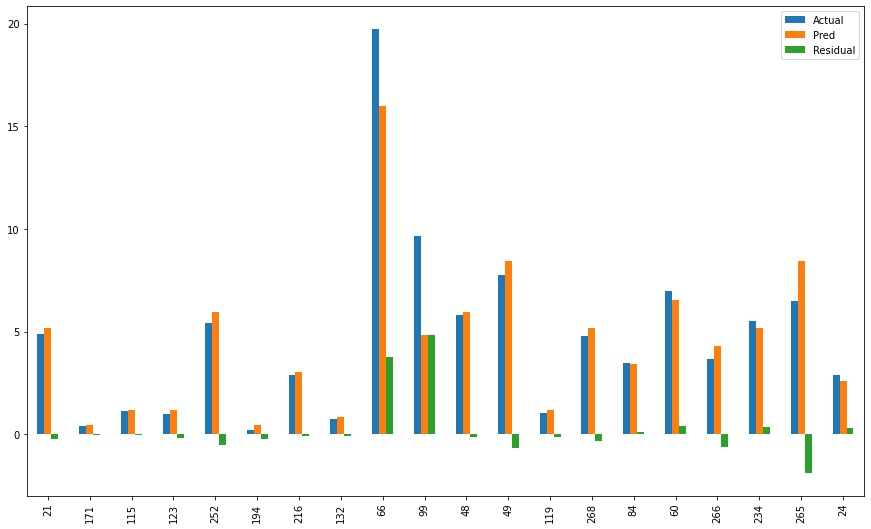

In [51]:
comp_sample.plot(kind='bar',figsize=(15,9))
plt.show()

<div class="alert alert-block alert-info" style="margin-top: 20px">
<h2>Random Forest</h2>
</div>

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
rf_model = RandomForestRegressor(random_state=101)

In [54]:
rf_model.fit(X_train,y_train)

RandomForestRegressor(random_state=101)

In [55]:
train_val(rf_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.986,0.973
mae,0.235,0.513
mse,0.348,0.725
rmse,0.590,0.851


### Cross-Validation

In [56]:
from sklearn.model_selection import cross_validate, cross_val_score
model = RandomForestRegressor(random_state=101)
scores = cross_validate(model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv =10)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                             0.862
test_neg_mean_absolute_error       -0.736
test_neg_mean_squared_error        -3.393
test_neg_root_mean_squared_error   -1.566
dtype: float64

### Feature Importance for Random Forest

In [57]:
rf_model.feature_importances_

array([2.34156850e-02, 8.66318271e-01, 1.73148579e-02, 2.14160300e-03,
       2.08393371e-03, 2.67174857e-03, 6.16411815e-05, 8.59922594e-02])

In [58]:
df_f_i = pd.DataFrame(index=X.columns, data = rf_model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance")
df_f_i

,Feature Importance
Owner,0.000
Seller_Type,0.002
Fuel_Type,0.002
Transmission,0.003
Kms_Driven,0.017
Car_Name,0.023
vehicle_age,0.086
Present_Price,0.866


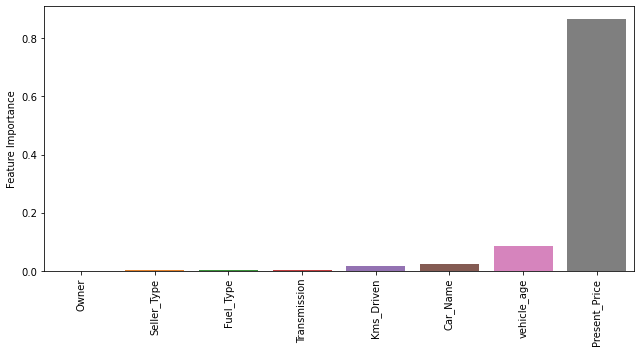

In [59]:
sns.barplot(x = df_f_i.index, y = 'Feature Importance', data = df_f_i)
plt.xticks(rotation = 90)
plt.tight_layout()

### Visualizing Trees

In [60]:
from sklearn.tree import plot_tree

def report_model(model):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print('\n')
    print(train_val(model, X_train, y_train, X_test, y_test))
    print('\n')
    plt.figure(figsize=(12,8),dpi=100)
    plot_tree(model.estimators_[0],filled=True, feature_names=X.columns, fontsize=10);

In [61]:
pruned_tree = RandomForestRegressor(n_estimators=250, max_depth=4, random_state=101)
pruned_tree.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, n_estimators=250, random_state=101)



      train  test
R2    0.963 0.941
mae   0.572 0.750
mse   0.953 1.577
rmse  0.976 1.256




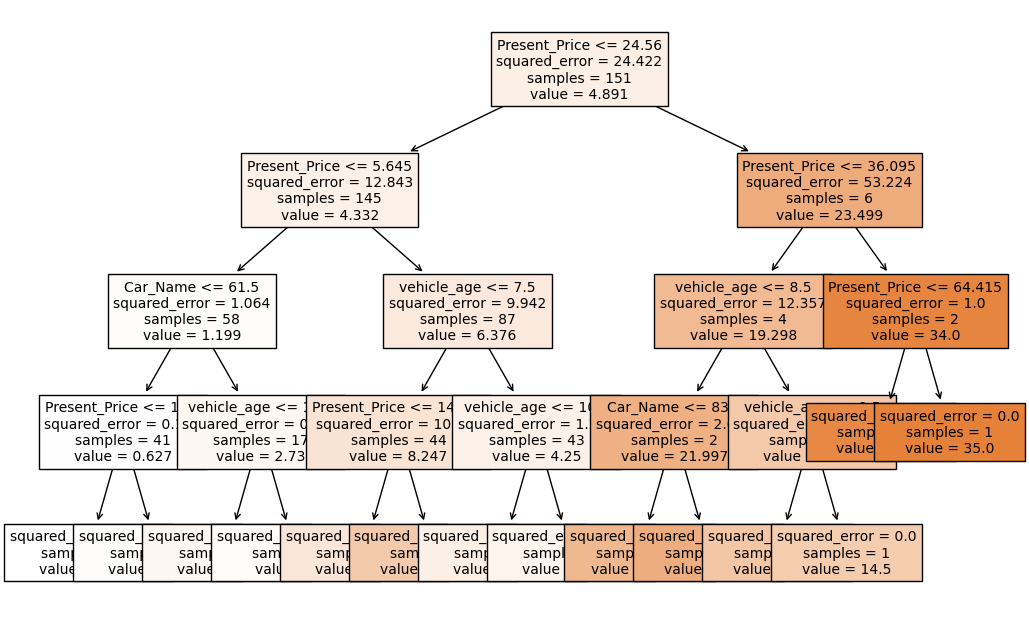

In [62]:
# scores with pruned_tree (max_depth=4)
report_model(pruned_tree)

### GridSearch for Random Forest

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
model = RandomForestRegressor(random_state=101)

In [65]:
param_grid = {"n_estimators":[64, 128, 200, 500],     
              "max_depth": [None, 4, 5, 6, 7,8],
              "min_samples_leaf": [1, 2, 3, 4],
              "min_samples_split": [2, 3, 5, 6],
              "max_features":['auto', len(df.columns)/3, 2, 4]}

In [66]:

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1)

In [67]:
grid_model.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': [None, 4, 5, 6, 7, 8],
                         'max_features': ['auto', 3.0, 2, 4],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 5, 6],
                         'n_estimators': [64, 128, 200, 500]},
             scoring='neg_root_mean_squared_error')

In [68]:
grid_model.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=128, random_state=101)

In [69]:
grid_model.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 128}

In [70]:
grid_score =pd.DataFrame(grid_model.cv_results_)
grid_score

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.191,0.014,0.017,0.011,None,auto,1,2,64,"{'max_depth': None, 'max_features': 'auto', 'm...",-0.599,-0.672,-1.995,-0.694,-1.774,-0.736,-2.778,-2.142,-0.833,-3.407,-1.563,0.956,114
1,0.399,0.015,0.023,0.013,None,auto,1,2,128,"{'max_depth': None, 'max_features': 'auto', 'm...",-0.602,-0.715,-2.131,-0.700,-1.716,-0.785,-2.770,-2.081,-0.702,-3.337,-1.554,0.946,103
2,0.582,0.041,0.037,0.010,None,auto,1,2,200,"{'max_depth': None, 'max_features': 'auto', 'm...",-0.606,-0.718,-2.085,-0.712,-1.731,-0.791,-2.741,-1.977,-0.635,-3.309,-1.530,0.933,64
3,1.419,0.070,0.072,0.010,None,auto,1,2,500,"{'max_depth': None, 'max_features': 'auto', 'm...",-0.603,-0.728,-1.920,-0.721,-1.690,-0.831,-2.715,-1.779,-0.684,-3.148,-1.482,0.872,15
4,0.175,0.019,0.012,0.009,None,auto,1,3,64,"{'max_depth': None, 'max_features': 'auto', 'm...",-0.633,-0.629,-2.047,-0.721,-1.284,-0.766,-2.698,-2.140,-0.838,-3.374,-1.513,0.938,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,1.146,0.027,0.072,0.011,8,4,4,5,500,"{'max_depth': 8, 'max_features': 4, 'min_sampl...",-0.825,-0.878,-1.211,-1.451,-0.912,-1.103,-3.250,-2.172,-0.826,-4.027,-1.665,1.073,539
1532,0.146,0.020,0.014,0.005,8,4,4,6,64,"{'max_depth': 8, 'max_features': 4, 'min_sampl...",-0.742,-0.928,-1.164,-1.523,-1.017,-1.107,-3.207,-2.209,-0.874,-4.392,-1.716,1.145,645
1533,0.278,0.006,0.021,0.008,8,4,4,6,128,"{'max_depth': 8, 'max_features': 4, 'min_sampl...",-0.776,-0.926,-1.200,-1.462,-1.014,-1.184,-3.294,-2.039,-0.870,-4.279,-1.704,1.118,634
1534,0.445,0.018,0.031,0.003,8,4,4,6,200,"{'max_depth': 8, 'max_features': 4, 'min_sampl...",-0.787,-0.919,-1.247,-1.448,-0.920,-1.184,-3.273,-2.067,-0.798,-4.125,-1.677,1.090,577


In [71]:
grid_model.best_index_

193

In [72]:
grid_model.best_score_

-1.4440454270480765

In [73]:
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.982,0.960
mae,0.257,0.530
mse,0.459,1.078
rmse,0.678,1.038


### Cross-Validation with the best_params

In [74]:
from sklearn.model_selection import cross_validate, cross_val_score

model = RandomForestRegressor(random_state=101, max_depth = None,
             max_features= 4,
             min_samples_leaf = 1,
             min_samples_split= 2,
             n_estimators= 200)
scores = cross_validate(model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv = 10)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                             0.894
test_neg_mean_absolute_error       -0.719
test_neg_mean_squared_error        -3.129
test_neg_root_mean_squared_error   -1.454
dtype: float64

In [75]:
y_pred = grid_model.predict(X_test)
my_dict = { 'Actual': y_test, 'Pred': y_pred, 'Residual': y_test-y_pred }
compare = pd.DataFrame(my_dict)

In [76]:
comp_sample = compare.sample(20)
comp_sample

,Actual,Pred,Residual
174,0.380,0.393,-0.013
216,2.900,3.339,-0.439
93,23.000,21.875,1.125
48,5.800,5.691,0.109
24,2.900,3.011,-0.111
194,0.200,0.337,-0.137
99,9.650,10.124,-0.474
266,3.650,4.042,-0.392
96,20.750,20.583,0.167
220,3.500,3.464,0.036


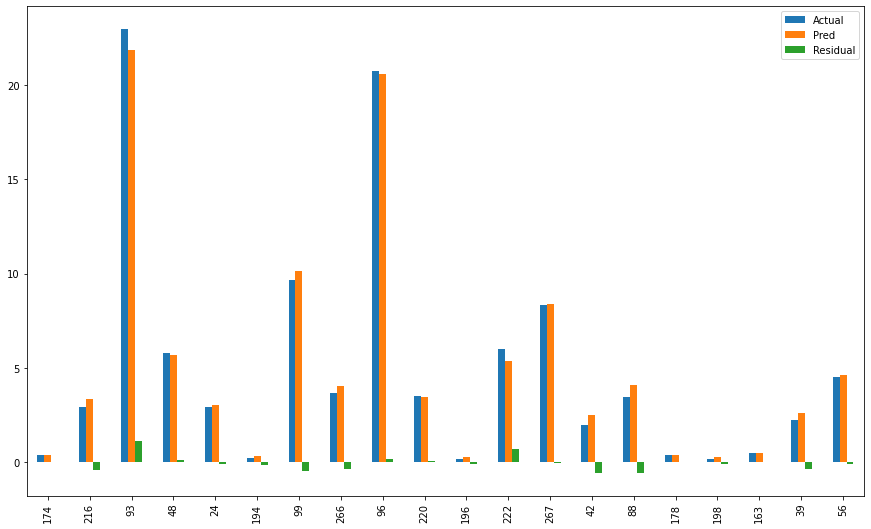

In [77]:
comp_sample.plot(kind='bar',figsize=(15,9))
plt.show()

## Comparison of the Models and Conclusion

***First, let's compare R2 and RMSE scores in Decision Trees before and after applying GridSearchCV.

- The scores in Decision Trees before GridSearchCV: R2 train:1.000; R2 test 0.952 and RMSE train:0.000;  RMSE test: 1.133. 
- The scores after GridSearchCV: R2 train: 0.979; R2 test: 0.929 and RMSE train: 0.724;  RMSE test: 1.384.

As mentioned above, we faced an overfitting problem in the Decision Trees model before applying GridSearchCV. After using GridSearchCV, it seems that the overfitting problem disappeared.

***Now, let's see R2 and RMSE scores in Random Forest before and after using GridSearchCV.

- Random Forest before GridSearchCV: R2 train: 0.986; R2 test: 0.973 and RMSE train: 0.590; RMSE test: 0.851.
- Random Forest with GridSearchCV: R2 train: 0.982;	R2 test: 0.960 and RMSE train:	0.678; RMSE test: 1.038.

The Random Forest model without GridSearchCV provided better scores. Compared to Decision Trees, we received the highest R2 (0.973) and the lowest RMSE (0.851) test scores in the Random Forest model. 
